# Method4 DCT based DOST + Huffman encoding

## Import Libraries

In [1]:
import mne
import numpy as np
from scipy.fft import fft,fftshift
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter
from scipy.signal import freqz
from scipy import signal
from scipy.fftpack import fft, dct, idct
from itertools import islice 


## Preprocessing

### Data loading

In [2]:
file = "/Users/lubaiying/Desktop/big_ideas_lab/DBDP_Compression_Toolbox/DCT_DOST_Huffman/ECG.EDF"
data = mne.io.read_raw_edf(file)
raw_data = data.get_data()
# you can get the metadata included in the file and a list of all channels:
info = data.info
channels = data.ch_names



np.savetxt('raw.txt',raw_data[0])  #Save it as a txt file
sampling_freq = 1/1000  #This is the sampling frequency
N = raw_data[0].size  #The number of point

ECG_array = raw_data[0] #Copy the data into an ndarray, which does the same thing with the former step
ECG_array.size

xf = np.linspace(-N*sampling_freq/2, N*sampling_freq/2,  N)

ECG_array = ECG_array[150000:-300000]  # Remove the signal in first 3minutes and last 5minutes

index = np.linspace(0, round((N-1)*sampling_freq,4), N)

Extracting EDF parameters from /Users/lubaiying/Desktop/big_ideas_lab/DBDP_Compression_Toolbox/DCT_DOST_Huffman/ECG.EDF...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


### Butterworth Filter to denoise

In [3]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

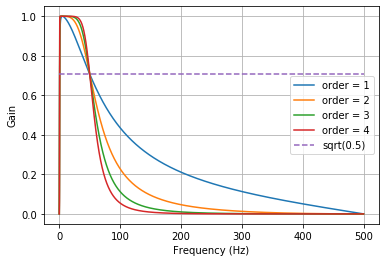

In [4]:

# Sample rate and desired cutoff frequencies (in Hz).
fs = 1000.0
lowcut = 0.5
highcut = 50.0

# Plot the frequency response for a few different orders.
plt.figure(1)
plt.clf()
for order in [1, 2, 3, 4]:
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    w, h = freqz(b, a, worN=2000)
    plt.plot((fs * 0.5 / np.pi) * w, abs(h), label="order = %d" % order)

plt.plot([0, 0.5 * fs], [np.sqrt(0.5), np.sqrt(0.5)],
         '--', label='sqrt(0.5)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.grid(True)
plt.legend(loc='best')

In [5]:
y = butter_bandpass_filter(ECG_array, lowcut, highcut, fs, order=2)

### Resampling and Quantization

In [6]:
resampled_signal = signal.resample(y, 564000)
np.savetxt('resampled_signal_ecg.txt',resampled_signal)
rounded_signal = np.around(resampled_signal, 5)

## Transformation

In [7]:
aN = dct(rounded_signal, type = 2, norm = 'ortho')

In [8]:
def return_N(target):
    if target > 1:
        for i in range(1, int(target)):
            if (2 ** i >= target):
                return i-1
    else:
        return 1

In [9]:
split_list = [1]
for i in range(0,return_N(aN.size)):
    split_list.append(2 ** i)
temp = iter(aN) 
res = [list(islice(temp, 0, ele)) for ele in split_list] 

In [10]:
cN_idct = [list(idct(res[0], type = 2, norm = 'ortho' )), list(idct(res[1], type = 2, norm = 'ortho' ))]
for k in range(2,len(res)):
    cN_idct.append(list(idct(res[k], type = 2, norm = 'ortho' )))

In [11]:
all_numbers = []
for i in cN_idct:
    for j in i:
        all_numbers.append(j)

In [12]:
all_numbers = np.asarray(all_numbers)
new_cN_idct = all_numbers*10**4
int_cN = np.round(new_cN_idct,4)

In [13]:
np.savetxt('resampled_signal_ecg.txt',resampled_signal,fmt='%.4f')
np.savetxt('int_cN.txt',int_cN, fmt='%.4f')

## Huffman Coding

### INSTRUCTION ON HOW TO COMPRESS THE DATA BY HUFFMAN CODING


(I used the package "tcmpr 0.2" and "pyhuff 1.1". These two packages provided the same compression result. So here, we just use "tcmpr 0.2")

1. Open your termial or git bash, enter "pip install tcmpr" to install the "tcmpr 0.2" package
2. Enter the directory which include the file you want to compress OR copy the path of the file you want to compress
3. Enter "tcmpr filename.txt" / "tcmpr filepath" to compress the file
4. Find the compressed file in the same directory of the original file

In [ ]:
# Do Huffman encoding based on the instruction above 
# or run this trunk if this scratch locates in the same directory with the signal you want to encode
os.system('tcmpr int_cN.txt')

## Reconstruction

In [ ]:
os.system('tcmpr -d int_cN.txt.huffman')
decoded_data = np.loadtxt(fname = "int_cN.txt")

In [14]:
recover_signal = decoded_data / 10**4
recover_signal = list(recover_signal)

In [15]:
split_list = [1]
for i in range(0,return_N(len(recover_signal))+1):
    split_list.append(2 ** i)
temp_recovered = iter(recover_signal) 
res_recovered = [list(islice(temp_recovered, 0, ele)) for ele in split_list] 

In [16]:
recover_dct = [list(dct(res_recovered[0], type = 2, norm = 'ortho' )), list(dct(res_recovered[1], type = 2, norm = 'ortho' ))]
for k in range(2,len(res_recovered)):
    recover_dct.append(list(dct(res_recovered[k], type = 2, norm = 'ortho' )))

In [17]:
all_recover = []
for i in recover_dct:
    for j in i:
        all_recover.append(j)
aN_recover = idct(all_recover, type = 2, norm = 'ortho')
final_recovered = aN_recover[:524288]

In [18]:
resampled_signal_shorter = signal.resample(y, len(final_recovered))
#resampled_signal_shorter = rounded_signal[:len(final_recovered)] 
from sklearn.metrics import mean_squared_error
from math import sqrt

def PRD_calculation(original_signal, compressed_signal):
    PRD = sqrt(sum((original_signal-compressed_signal)**2)/(sum(original_signal**2)))
    return PRD

PRD = PRD_calculation(resampled_signal_shorter, final_recovered)
print("The PRD is {}%".format(round(PRD*100,3)))

The PRD is 4.085%


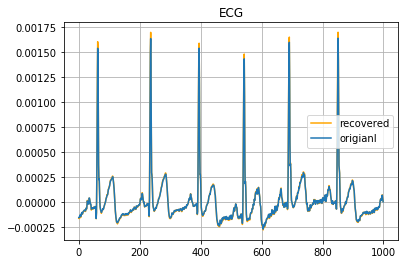

In [19]:
#plt.plot(resampled_signal_shorter[74000:75000], label = "origianl")
resampled_signal_shorter = signal.resample(y, len(final_recovered))
plt.plot(final_recovered[74000:75000], label = "recovered", color = 'orange')
plt.plot(resampled_signal_shorter[74000:75000], label = "origianl")
plt.legend()
plt.title('ECG')
plt.grid()
plt.show()